In [ ]:
!pip install gym

In [15]:
%load_ext autoreload
%autoreload 2
from src.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import traceback

all_transplants, _ = read_organ_data()

In [43]:
all_transplants = all_transplants.dropna(subset=[Column.DONOR_ID.name, Column.ORGAN_TRANSPLANT_ID.name, Column.ORGAN_RECOVERY_DATE.name, Column.TRANSPLANT_DATE.name, Column.END_DATE.name]).sort_values(by=Column.TRANSPLANT_DATE.name)
# all_transplants[[Column.DONOR_ID.name, Column.ORGAN_TRANSPLANT_ID.name, Column.ORGAN_RECOVERY_DATE.name, Column.TRANSPLANT_DATE.name, Column.END_DATE.name]].sort_values(by=Column.TRANSPLANT_DATE.name)

/var/folders/q2/gnk279t14ll2b2fsw_hb6y_c0000gn/T/ipykernel_79248/697766735.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transplants['Year'] = filtered_transplants[Column.ORGAN_RECOVERY_DATE.name].dt.year
/var/folders/q2/gnk279t14ll2b2fsw_hb6y_c0000gn/T/ipykernel_79248/697766735.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transplants['Month'] = filtered_transplants[Column.ORGAN_RECOVERY_DATE.name].dt.month


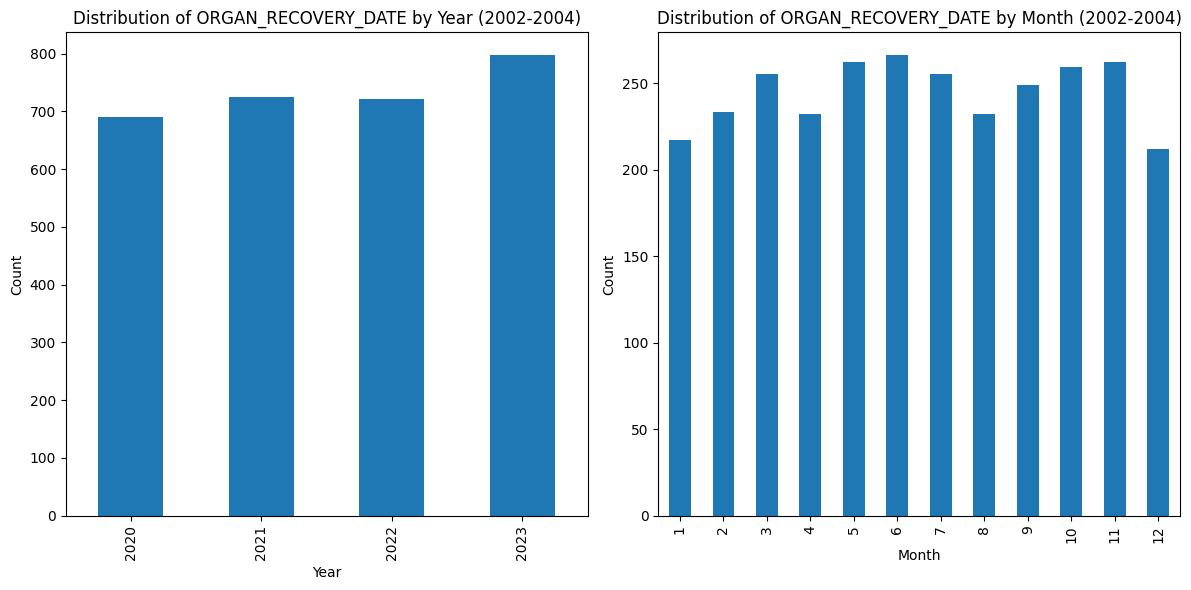

In [45]:
import matplotlib.pyplot as plt

# Filter data for the years 2002-2004
filtered_transplants = all_transplants[
    (all_transplants[Column.ORGAN_RECOVERY_DATE.name] >= '2020-01-01') & 
    (all_transplants[Column.ORGAN_RECOVERY_DATE.name] <= '2023-12-31')
]

# Extract year and month from ORGAN_RECOVERY_DATE
filtered_transplants['Year'] = filtered_transplants[Column.ORGAN_RECOVERY_DATE.name].dt.year
filtered_transplants['Month'] = filtered_transplants[Column.ORGAN_RECOVERY_DATE.name].dt.month

# Plot distribution by year
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
filtered_transplants['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of ORGAN_RECOVERY_DATE by Year (2002-2004)')
plt.xlabel('Year')
plt.ylabel('Count')

# Plot distribution by month
plt.subplot(1, 2, 2)
filtered_transplants['Month'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of ORGAN_RECOVERY_DATE by Month (2002-2004)')
plt.xlabel('Month')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
highest_rows_per_recovery_date = all_transplants.groupby(Column.ORGAN_RECOVERY_DATE.name).size().max()
highest_rows_per_recovery_date


In [78]:
date = pd.Timestamp('2002-04-03')
available_organs = get_mininal_columns_available_organs(by_date=date)

In [79]:
available_organs

,DONOR_ID,DONOR_BLOOD_TYPE,DONOR_BLOOD_TYPE_AS_CODE,ORGAN_RECOVERY_DATE
0,183045,O,7,2002-04-02
1,319621,B,6,2002-04-03
2,158846,O,7,2002-04-03


In [ ]:
waitlist_members = get_mininal_columns_waitlist(by_date=date)

In [ ]:
waitlist_members.head(5)

In [ ]:
WAITLIST_FEATURES = [
        Column.RECIPIENT_ID.name, 
        Column.INIT_MELD_PELD_LAB_SCORE.name, 
        Column.DAYS_ON_WAITLIST.name,
        Column.RECIPIENT_BLOOD_TYPE.name,
        Column.RECIPIENT_BLOOD_TYPE_AS_CODE.name,
]
sample_waitlist_members = waitlist_members[WAITLIST_FEATURES].head(5)
sample_waitlist_members

In [13]:
def compare_to_baseline(current_date: pd.Timestamp, end_date: pd.Timestamp):
    total_graft_lifespan = 0
    total_patient_survival_time = 0

    date = current_date
    allocated_ids = []
    while date <= end_date:
        # Get the next day's data
        date, [organs, waitlist_members] = get_next_day(date, allocated_ids=allocated_ids)
        donor_ids = waitlist_members[waitlist_members[Column.TRANSPLANT_DATE.name] == date][Column.DONOR_ID.name].unique()
        allocated_ids.extend(donor_ids)
        waitlist_members = waitlist_members[waitlist_members[Column.TRANSPLANT_DATE.name] == date]

        # Sum up the GRAFT_LIFESPAN and PATIENT_SURVIVAL_TIME for the current day's waitlist members
        total_graft_lifespan += waitlist_members[Column.GRAFT_LIFESPAN.name].sum()
        total_patient_survival_time += waitlist_members[Column.PATIENT_SURVIVAL_TIME.name].sum()
        date += pd.Timedelta(days=1)

    return total_graft_lifespan + total_patient_survival_time

In [ ]:
reward  = compare_to_baseline(pd.Timestamp('02-04-24'), pd.Timestamp('02-10-24'))

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQN(nn.Module):
    def __init__(self, state_shape, action_size, hidden_size=64):
        super(DQN, self).__init__()
        # Flatten the state shape to get the input size for the first layer
        input_size = state_shape[0] * state_shape[1]
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done, info):
        self.memory.append((state, action, reward, next_state, done, info))
        
    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones, infos = zip(*batch)
        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.int64),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.bool_),
                infos)
        
    def __len__(self):
        return len(self.memory)

In [46]:
class OrganMatchingEnv:
    def __init__(self, max_waitlist_members: int = 10, max_days: int = 3):
        """
        Args:
            max_waitlist_members: The number of max people to consider on the waitlist (it is sorted by MELD and days on waitlist)                             
            max_days: The horizon over which we measure performance or run the simulation.

        We assume:
        - Each day we have multiple donors and multiple recipients.
        - Each step in the environment involves selecting a recipient for the **current donor**.
          After all donors for that day are processed, we move to the next day.
        """
        self.initial_date = pd.Timestamp(f'2020-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}')
        self.max_waitlist_members = max_waitlist_members
        self.max_days = max_days

        self.current_day_idx = self.initial_date
        self.current_donor_idx = 0
        self.total_days_allocated = -1

        # These will be set at reset
        self.available_donor_df = None
        self.waitlist_member_df = None
        self.donor_ids_allocated = set()

    def reset(self):
        self.total_days_allocated = -1
        self.initial_date = pd.Timestamp(f'2020-{random.randint(1, 12):02d}-{random.randint(1, 28):02d}')
        self.current_donor_idx = 0
        self.donor_ids_allocated = set()
        self.refetch_data(self.initial_date)
        return self._get_state()
    
    def refetch_data(self, date: pd.Timestamp):
        logging.info(f'Refetching data for date: {date}. Allocated donor IDs: {self.donor_ids_allocated}')
        self.current_day_idx, data = get_next_day(date, allocated_ids=self.donor_ids_allocated)
        self.available_donor_df = data[0]
        self.waitlist_member_df = data[1]
        # Check if there are any donors left to allocate
        available_donors = self.available_donor_df[Column.DONOR_ID.name].tolist()
        unallocated_donors = [i for i, donor_id in enumerate(available_donors) if donor_id not in self.donor_ids_allocated]
        if len(unallocated_donors) == 0:
            logging.info(f'WARNING: No unallocated donors available for date: {self.current_day_idx}')
            self.current_donor_idx = len(self.available_donor_df)  # Set to an invalid index
        else:
            self.current_donor_idx = unallocated_donors[0]
        
        if date < self.current_day_idx:
            logging.info(f'Moving onto next day {self.current_day_idx} with donor index {self.current_donor_idx} for donor ID: {self._get_donor()}')
        else: 
            logging.info(f'Staying on {self.current_day_idx} to keep allocating for donor idx {self.current_donor_idx} because we have the remaining donors: {self._get_remaining_donors()}')
    
    def _get_valid_actions_for_df(self, donor_id: int, organs: pd.DataFrame, waitlist: pd.DataFrame):
        donor = organs.iloc[donor_id]
        donor_blood_type = donor[Column.DONOR_BLOOD_TYPE.name]
        valid_allocations = [i for i in range(len(waitlist)) if get_match_value(donor_blood_type=donor_blood_type, recipient_blood_type=waitlist.iloc[i][Column.RECIPIENT_BLOOD_TYPE.name]) >= 1.0]
        return valid_allocations
    
    def _get_remaining_donors(self):
        return self.available_donor_df[Column.DONOR_ID.name].tolist()

    def get_valid_actions(self):
        return self._get_valid_actions_for_df(self.current_donor_idx, self.available_donor_df, self.waitlist_member_df)

    def _get_state(self):
        self.refetch_data(self.current_day_idx)
        encoded_array = np.array([
            list(row) for row in zip(self.waitlist_member_df[Column.RECIPIENT_ID.name], 
                                    self.waitlist_member_df[Column.INIT_MELD_PELD_LAB_SCORE.name], 
                                    self.waitlist_member_df[Column.DAYS_ON_WAITLIST.name], 
                                    self.waitlist_member_df[Column.RECIPIENT_BLOOD_TYPE_AS_CODE.name])
        ])
        state = np.array(encoded_array, dtype=np.float32)
        return state
    
    def _get_donor(self):
        return int(self.available_donor_df.iloc[self.current_donor_idx][Column.DONOR_ID.name])
    
    def _get_chosen_recipient(self, action: int):
        if action > len(self.waitlist_member_df):
            return pd.Series.empty()
        return self.waitlist_member_df.iloc[action]

    def step(self, action: int):
        """
        Args:
            action: index corresponding to the chosen recipient in waitlist_member_df.
                    This means action is in [0, max_waitlist_members_to_consider].
        
        Returns:
            next_state: state after this allocation
            reward: float, e.g. graft lifespan or related metric
            done: bool, whether the episode ended
            info: dict, extra info
        """
        chosen_recipient = self._get_chosen_recipient(action)
        self.total_days_allocated += 1
        self.donor_ids_allocated.add(self._get_donor())
        self.donor_ids_allocated.add(int(chosen_recipient[Column.DONOR_ID.name]))
        reward = 0.0
        if chosen_recipient.empty:
            reward = -1000
        else:  
            # It doesn't matter who they got the organ from. Just include the rewards of this person getting an organ.
            if chosen_recipient[Column.GRAFT_LIFESPAN.name] is not None:
                reward += float(chosen_recipient[Column.GRAFT_LIFESPAN.name])
            if chosen_recipient[Column.GRAFT_LIFESPAN.name] is not None:
                reward += float(chosen_recipient[Column.PATIENT_SURVIVAL_TIME.name])
        chosen_donor = self._get_donor()
        logging.info(f'''Chose recipient ID: {chosen_recipient[Column.RECIPIENT_ID.name]} for donor {chosen_donor} with : {reward}''')

        done = (self.total_days_allocated >= self.max_days)
        valid_allocations = []
        invalid_allocations = []
        if not done:
            next_state = self._get_state()
            next_actions = np.arange(self.max_waitlist_members)
            valid_allocations = self.get_valid_actions()
            invalid_allocations = [i for i in next_actions if i not in valid_allocations]
        else:
            next_state = np.zeros_like(self._get_state())

        return next_state, reward, done, {'next_valid_allocations': valid_allocations, 'next_invalid_allocations': invalid_allocations}

In [ ]:
done = False
env = OrganMatchingEnv()
env.reset()
total_reward = 0
while not done:
    valid_actions = env.get_valid_actions()
    next_state, reward, done, _ = env.step(random.choice(valid_actions))
    total_reward += reward
    print(f'Reward: {total_reward} and reached done? {done}')

In [38]:
from tqdm import tqdm

def train_dqn(env: OrganMatchingEnv,
              episodes: int =100,
              gamma: float=0.99,
              epsilon_start: float = 1.0,
              epsilon_end: float = 0.01,
              epsilon_decay: int = 500,
              lr: float = 1e-3,
              batch_size: int = 2,
              memory_capacity: int = 100,
              target_update: int = 10):
    # Initialize replay memory
    memory = ReplayMemory(memory_capacity)

    state = env.reset()
    state_size = state.shape
    action_size = env.max_waitlist_members
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    epsilon = epsilon_start
    steps_done = 0
    all_rewards = []
    organs_allocated = []
    
    for ep in tqdm(range(episodes), desc="Training Episodes"):
        state = env.reset()
        done = False
        episode_reward = 0.0
        episode_organs = 0
        
        while not done:
            steps_done += 1

            # The actual available actions on this step is equal to the current day's recipients
            actions = np.arange(action_size)
            valid_allocations = env.get_valid_actions()
            invalid_allocations = [i for i in actions if i not in valid_allocations]
            
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                # Random action from the valid range of recipients
                action = random.choice(valid_allocations)
            else:
                with torch.no_grad():
                    q_values = policy_net(torch.tensor([state], dtype=torch.float32))
                    # Mask out invalid actions by setting Q-values of invalid actions to a large negative number
                    q_values[0, invalid_allocations] = -1e9
                    action = q_values.argmax(dim=1).item()

            next_state, reward, done, info = env.step(action)
            episode_reward += reward
            
            memory.push(state, action, reward, next_state, done, info)
            episode_organs += 1
            state = next_state

            # Train if memory is sufficient
            if len(memory) >= batch_size:
                states_b, actions_b, rewards_b, next_states_b, dones_b, infos = memory.sample(batch_size)
                
                states_t = torch.tensor(states_b, dtype=torch.float32, device=device)
                # size (batch size)
                actions_t = torch.tensor(actions_b, device=device).unsqueeze(1)
                rewards_t = torch.tensor(rewards_b, dtype=torch.float32, device=device)
                next_states_t = torch.tensor(next_states_b, dtype=torch.float32, device=device)
                dones_t = torch.tensor(dones_b, dtype=torch.bool, device=device)
                
                # Compute Q(s,a)
                q_values = policy_net(states_t.view(batch_size, -1)).gather(1, actions_t)
                
                # Compute max Q(s',a') from target net
                next_q_values_all = target_net(next_states_t.view(batch_size, -1))

                # next_q_values_all is (batch_size, action_size)
                for batch_idx, info_entry in enumerate(infos):
                    invalid_allocations = info_entry['next_invalid_allocations']
                    next_q_values_all[batch_idx, invalid_allocations] = -1e9

                next_q_values = next_q_values_all.max(1)[0]
                next_q_values[dones_t] = 0.0
                
                target = rewards_t + gamma * next_q_values
                
                loss = nn.MSELoss()(q_values.squeeze(), target)
                print('---------------------------------------------------------------------------------------')
                print(f"Loss with target {ep}/{episodes}, Loss: {loss.item():,.2f}")
                print('---------------------------------------------------------------------------------------')
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Decay epsilon
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-steps_done / epsilon_decay)
        
        # Update target network
        if ep % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
            # Save the policy net to a pkl file
            with open(f'policy_net_ep{ep}.pkl', 'wb') as f:
                torch.save(policy_net.state_dict(), f)
        all_rewards.append(episode_reward)
        organs_allocated.append(episode_organs)
        print('***************************************************************************************')
        print(f"Episode {ep+1}/{episodes}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.2f}")
        print('***************************************************************************************')
    
    return policy_net, all_rewards, organs_allocated

In [47]:
env = OrganMatchingEnv(max_days=50)
trained_policy = train_dqn(env, episodes=3)

INFO:root:Refetching data for date: 2020-08-01 00:00:00. Allocated donor IDs: set()
INFO:root:Staying on 2020-08-01 00:00:00 to keep allocating for donor idx 0 because we have the remaining donors: [588431]
INFO:root:Refetching data for date: 2020-08-01 00:00:00. Allocated donor IDs: set()
INFO:root:Staying on 2020-08-01 00:00:00 to keep allocating for donor idx 0 because we have the remaining donors: [588431]
Training Episodes:   0%|          | 0/3 [00:00<?, ?it/s]INFO:root:Refetching data for date: 2020-09-28 00:00:00. Allocated donor IDs: set()
INFO:root:Staying on 2020-09-28 00:00:00 to keep allocating for donor idx 0 because we have the remaining donors: [592865]
INFO:root:Refetching data for date: 2020-09-28 00:00:00. Allocated donor IDs: set()
INFO:root:Staying on 2020-09-28 00:00:00 to keep allocating for donor idx 0 because we have the remaining donors: [592865]
INFO:root:Chose recipient ID: 1365409 for donor 592865 with : 1950.0
INFO:root:Refetching data for date: 2020-09-28 

INFO:root:Moving onto next day 2020-09-29 00:00:00 with donor index 0 for donor ID: 592840
INFO:root:Chose recipient ID: 1309298 for donor 592840 with : 698.0
INFO:root:Refetching data for date: 2020-09-29 00:00:00. Allocated donor IDs: {592840, 592865, 651298, 598181}
INFO:root:Staying on 2020-09-29 00:00:00 to keep allocating for donor idx 0 because we have the remaining donors: [592750, 592671]


---------------------------------------------------------------------------------------
Loss with target 0/3, Loss: 47185612800.00
---------------------------------------------------------------------------------------


INFO:root:Chose recipient ID: 1367557 for donor 592750 with : 2112.0
INFO:root:Refetching data for date: 2020-09-29 00:00:00. Allocated donor IDs: {592865, 651298, 598181, 592840, 592750, 592671}


INFO:root:Moving onto next day 2020-09-30 00:00:00 with donor index 0 for donor ID: 592889


---------------------------------------------------------------------------------------
Loss with target 0/3, Loss: 6200859648.00
---------------------------------------------------------------------------------------


INFO:root:Chose recipient ID: 1318822 for donor 592889 with : 314.0
INFO:root:Refetching data for date: 2020-09-30 00:00:00. Allocated donor IDs: {592865, 651298, 598181, 592840, 619245, 592750, 592889, 592671}
